# Summing or concatenating embeddings?
In neural networks, there are often cases where you might have two or more vectors from different sources, e.g. outputs of parallel networks like in the multihead attention of the Transformer or multiple embeddings from multiple categorical variables as inputs.

One common way of dealing with this is to _concatenate_ the multiple vectors to a single result. Let's say we have two column vectors $\mathbf{u}$ and $\mathbf{v}$, then we think of the concatenation as:

$$ \mathbf{x} = \begin{bmatrix} \mathbf{u} \\ \mathbf{v} \end{bmatrix}$$


What we'll argue in this notebook is that a neater way of combining the vectors is by instead using a sum:

$$ \mathbf{x} = \mathbf{u} + \mathbf{v}$$

For _embeddings_ in particular we'll make a strong argument for this.


## Why is summing embeddings better than concatenation for aggregating vectors?

First we rely on these assumptions:
 - The vectors to sum consists of _free parameters_ or are some result from a computation including free parameters, they are free to take any value by our optimzation procedure.
 - We will apply a linear transformation to the result of the aggregation
 - the dimensionality of the aggregation result is the same for both aggregation methods


### Problem with concatenation - decide on dimensionality
First, consider aggregating by concatenation

 $$ \mathbf{x} = \begin{bmatrix} \mathbf{u} \\ \mathbf{v} \end{bmatrix}$$


 Now let $\mathbf{x} \in \mathord{R}^d$, then $\mathbf{u} \in \mathord{R}^k, k < d$ and $\mathbf{u} \in \mathord{R}^{d-k}$. 

In other words, we have to select the dimensionality of $\mathbf{u}$ and $\mathbf{v}$ so that it adds up to the desired $d$. How do we do this? Which of the vectors $\mathbf{u}$ and $\mathbf{v}$ _needs_ the most capacity?

If we instead use sums: 

$$ \mathbf{x} = \mathbf{u} + \mathbf{v}$$

It's easy to see that we just have the same dimensionality: $\mathbf{x}, \mathbf{u},  \mathbf{v} \in \mathord{R}^d$

### Implementing concatenation using a sum
One argument for why sums are at least as exprissive as concatenation is to see that we can actually implement concatenation using sum. Let's say we have decided on some dimensionality of our $\mathbf{u}$ and $\mathbf{v}$. We now have that  $\mathbf{u}$ and $\mathbf{v}$ are

$$
\mathbf{u} = \begin{bmatrix} 
u_1\\
\vdots\\
u_k
\end{bmatrix}
\mathbf{v} = \begin{bmatrix} 
v_1\\
\vdots\\
v_{d-k}
\end{bmatrix}$$

and

$$ 
\mathbf{x} = \begin{bmatrix} \mathbf{u} \\ \mathbf{v} \end{bmatrix} = 
 \begin{bmatrix} 
u_1\\
\vdots\\
u_k\\
v_1\\
\vdots\\
v_{d-k}
\end{bmatrix}$$

Now if we instead construct $0$-padded version of $\mathbf{u}$ and $\mathbf{v}$, $\mathbf{u}'$ and $\mathbf{v}'$


$$
\mathbf{u}' = \begin{bmatrix} 
u_1\\
\vdots\\
u_k\\
0\\
\vdots\\
0
\end{bmatrix}
\mathbf{v}' = \begin{bmatrix} 
0\\
\vdots\\
0\\
v_1\\
\vdots\\
v_{d-k}
\end{bmatrix}$$

We can implement the concatenation using this sum

$$\mathbf{x} = \begin{bmatrix} \mathbf{u} \\ \mathbf{v} \end{bmatrix} = 
\mathbf{u}' + \mathbf{v}'
$$

So you see that concatenation can be seen as a special case of a sum by constructing the vectors to sum in a specific manner. 

In general though, we would not set parts of the vectors to sum to hard zeros, instead having them filled with values which the optimization procedure is free to use however is appropriate. This is a difference, the concatenation explicitly separates the subspaces for the vectors, which means that _learning_ dynamics might behave differently. 

An analogy is to that of fully connected neural networks vs. convolutional. A convolutional layer can be seen as a special case of a fully connected layers, where many of the weights are hard zeroes and many of the other weights are tied. This constraint actually makes CNNs much more data efficient, in that they exploit prior beliefs about how to analyze spatially correlated date. 

This bias of concatenation to behave as sums of vectors in orthogonal subspaces can be useful when you _do_ want to concatenate vectors but your framework might be limited (e.g. concatenating multiple tensors in a single operation).



## Concatenation and sums when followed by a linear transformation

There's a better argument for summing instead of concatenating if we also assume that this aggregation will be multiplied with a matrix (as is often the case in neural networks).

In that case, lets say we concatenate the vectors of _free variables_ $\mathbf{u}$ and $\mathbf{v}$:

$$\mathbf{x} = \begin{bmatrix} \mathbf{u} \\ \mathbf{v} \end{bmatrix}$$

Then the matrix multiplication $W \mathbf{x}$ is the same as 
$$
W \mathbf{x} = W_u \mathbf{u} + W_v \mathbf{v}
$$

Where $W = \begin{bmatrix} W_u & W_v \end{bmatrix}$

If we use concatenation, the matrix-vector multiplication that the concatenation encounters will essentially perform a _sum_ of the concatenated vectors _after_ they have been linearily transformed. 

Since all the matrices and vectors are _freely parameterized_, we might just set $W_u = W_v$ and not loose anything in terms of expressivity, especially if we increase the dimensionality of $\mathbf{u}$ and $\mathbf{v}$ to match the one the concatenation would have had.

Another way to think about this is to consider where $\mathbf{u}$ and $\mathbf{v}$ come from. Let's say that they are actually the $i$th and $j$th column of two _embedding_ matrices $E_u$ and $E_v$ (using numpy slice notation):

$$\mathbf{u} = E_u[:,i]$$
$$\mathbf{v} = E_u[:,j]$$

Then 

$$
W \mathbf{x} = W_u \mathbf{u} + W_v \mathbf{v} =  W_u E_u[:,i] + W_v E_u[:,j] 
$$

Since these operations are associative, that is $W (E[:,i]) = (W E)[:, i]$, we might as well just set our embeddings to 


$$E_u' = (W_u E_u), E_v' = (W_v E_v)$$ 


and use sum to achieve the exact same thing as concatenation would have achieved. Since these are all just free parameters (typically randomly initialized), the only difference between $E$ and $E'$ is the random distribution the values are drawn from.

##An argument **for** concatenation 

If we would like our combination of vectors to _not_ be permutation invariant, we _might_ want to use concatenation. Let's say the vectors we want to combine are actually a sequence, where each position in the sequence will be represented by a vector, but this might be the _same_ vector.

$S_1 = \text{"a white cat visited the house"}$

$S_2 = \text{"a cat visited the white house"}$

In this case, concatenation makes more sense

$$S_1 = \begin{bmatrix} \mathbf{x}_\text{a} \\ \mathbf{x}_\text{white} \\ \mathbf{x}_\text{cat} \\ \mathbf{x}_\text{visited} \\ \mathbf{x}_\text{the} \\  
\mathbf{x}_\text{house} \\  
\end{bmatrix}$$

$$S_2 = \begin{bmatrix} \mathbf{x}_\text{a} \\ \mathbf{x}_\text{cat} \\ \mathbf{x}_\text{visited} \\ \mathbf{x}_\text{the} \\ \mathbf{x}_\text{white} \\ 
\mathbf{x}_\text{house} 
\end{bmatrix}$$


$$
W S_1 = W_1 \mathbf{x}_\text{a} + W_2\mathbf{x}_\text{white} + W_3\mathbf{x}_\text{cat} + W_4 \mathbf{x}_\text{visited} + W_5\mathbf{x}_\text{the} +  W_6\mathbf{x}_\text{house} 
$$

$$
W S_2 = W_1 \mathbf{x}_\text{a} + W_2\mathbf{x}_\text{cat} + W_3\mathbf{x}_\text{visited} + W_4 \mathbf{x}_\text{the} + W_5\mathbf{x}_\text{white} +  W_6\mathbf{x}_\text{house} 
$$

So in this case, assuming that the $\mathbf{x}$'s are fixed, the model can learn to _project_ them differently depending on _position_ in the input concatenation. The word vector $W_5\mathbf{x}_\text{white}$ will be different from $W_2\mathbf{x}_\text{white}$, even though it's the same word.

If we instead summed them, we could not separate these two sentence representations.

Conversely, if we do want permutation invariance, concatenation is problematic since

$$
 W_1 \mathbf{x}_1 + W_2 \mathbf{x}_2 \neq W_1 \mathbf{x}_2 + W_2 \mathbf{x}_2
$$

So if the combination _should_ be permutation invariant, this will cause issues (the network can still _learn_ to treat them permutation invariant learning similar  $W_1$ and $W_2$, but this will require much more training).

We could _still_ achieve the same thing using sums by having different embeddings based on position, so $\mathbf{x}_\text{2, white}$ 
will be different from $\mathbf{x}_\text{5, white}$

In practice, this would mean we create separate Embeddings for each position.

## Sums of vectors in high dimensions
Intuitively, summing vectors _feels_ wrong, since we're essentially making information hard to disentangle. Let's say we have som set of numbers $X = \{x_1, ..., x_n\}$ and we form some value $y = x_i + x_j$. It's difficult to determine exactly which numbers went into this sum, especially if the sum could have any number of terms. This intuition also tells us that summing vectors (so $X = \{ \mathbf{x}_1, ... \mathbf{x}_n\}$) should be bad, wont we do the same thing as before?

We'll make some experiments with sums of vectors and see how destructive this operation is

In [ ]:
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt


np.random.seed(1729)

num_values = 32
sample_sizes = [10, 50, 100, 500]

raw_data_samples = {}
for sample_size in sample_sizes:
  raw_data_sample = np.random.choice(num_values, size=sample_size)
  raw_data_samples[sample_size] = raw_data_sample

In [ ]:
embedding_dims = [2, 16, 24, 32, 64, 128]
embeddings_by_dim = {}
num_embeddings = num_values
for embedding_dim in embedding_dims:
  # We want to make embeddings have the same values in overlapping dimensions
  # We reset the random seed to the same value to achieve this
  # Numpy assumes c-contiguous order, so we need to generate the embeddings in
  # transpose, and then transpose them back
  np.random.seed(1729)  
  # This is the transpose of how we would typically have the embeddings laied out
  embeddings_T = np.random.randn(embedding_dim, num_embeddings)  
  embeddings = embeddings_T.T  # Transpose them so they are in the assumed layout
  embeddings_by_dim[embedding_dim] = embeddings

Now let's creat our summed embeddings for the different sample sizes and embedding dimensionalities

In [ ]:
embedded_samples = {}
for sample_size, raw_data_sample in raw_data_samples.items():
  for embedding_dim, embeddings in embeddings_by_dim.items():
    embedded_sample = embeddings[raw_data_sample]
    summed_vectors = embedded_sample.sum(axis=0)
    embedded_samples[(sample_size, embedding_dim)] = summed_vectors


We have now created sums of vectors for different number of vectors and different embedding dimensions. Let's see if we can figure out what embedding vectors, and how many of them where actually part of these sums.

We use a simple iterative algorithm which compares the sum using cosine similarity (dot product between normalized vectors) to at each iteration pick the vector with the highest cosine similarity to the sum at retracting that vector from the sum.

In [ ]:
def estimate_vector_counts(vector_sum, embeddings, n):
  '''Try to figure out what vectors from *embeddings* was part of the 
  *vector_sum* of *n* vectors'''
  # We'll use the cosine similarity to select the top vector at each iteration
  embeddings_normalized = embeddings / np.linalg.norm(embeddings, 
                                                  axis=1, 
                                                  keepdims=True)
  x = vector_sum[:]
  counts = Counter()
  for i in range(n):
    x_normalized = x / np.linalg.norm(x)
    cosine_sim = embeddings_normalized @ x_normalized
    top_emb_idx = np.argmax(cosine_sim)
    top_emb_vec = embeddings[top_emb_idx]
    x = x - top_emb_vec
    counts[top_emb_idx] += 1
  return counts


Below we illustrate how well we can pick out vectors using this simple method. The histograms at each subfigure shows us the true count of the different vectors in blue, and the estimated count in orange.

As you can see, when the embedding dimension increases, the ability to pick out the vector sum improves dramatically. This isn't really suprising. If we had one-hot vectors representing the data, we could easily do the same by just looking at the count at each position, but you can see that we're still getting decent results with an embedding dimension which is less than the number of vectors even though the embedding are random.

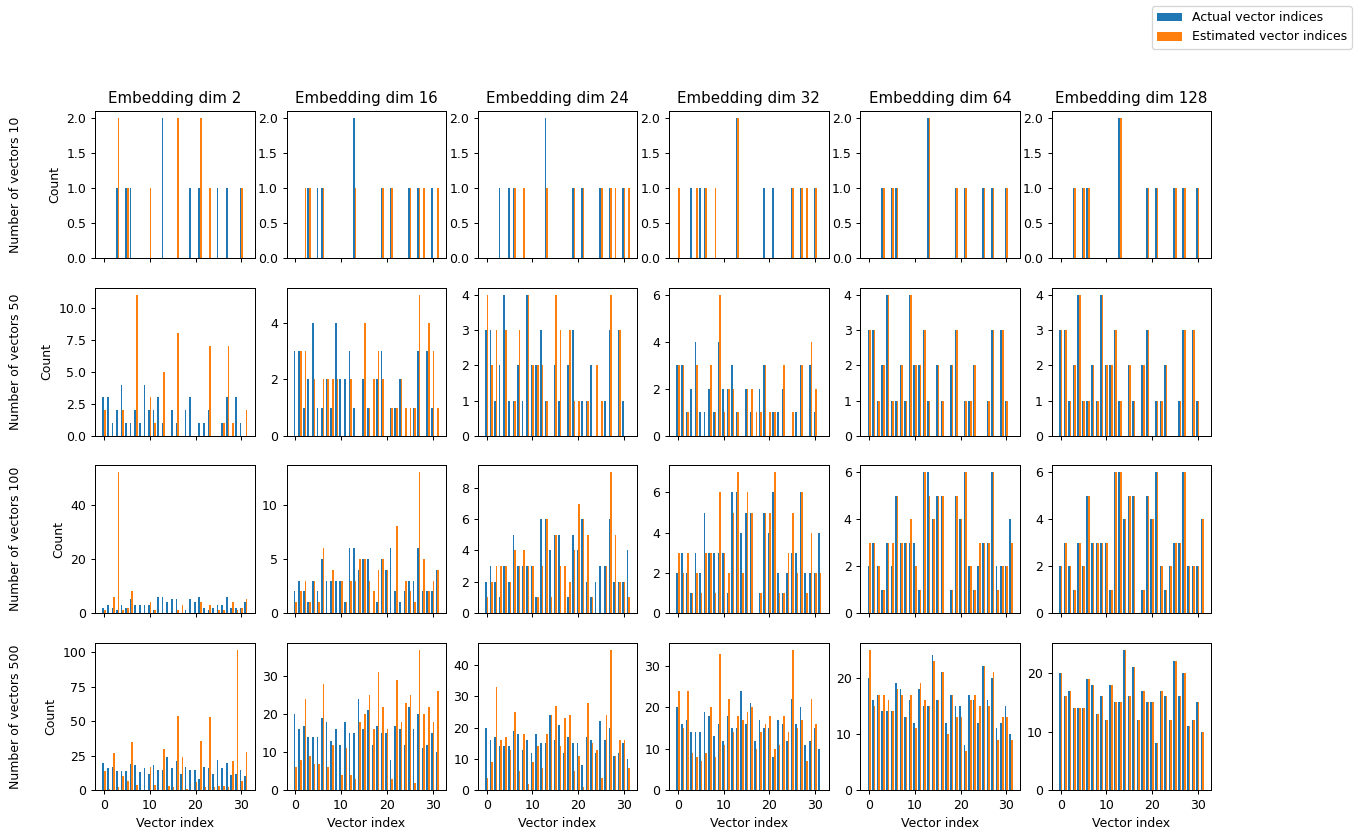

In [ ]:
fig, axes = plt.subplots(nrows=len(sample_sizes), ncols=len(embedding_dims), figsize=(16,10), sharex='all', sharey='none', dpi=90)

legend = None

for i, sample_size in enumerate(sample_sizes):
  for j, embedding_dim in enumerate(embedding_dims):
    true_sample_count = Counter(raw_data_samples[sample_size])
    embeddings = embeddings_by_dim[embedding_dim]
    vector_sum = embedded_samples[(sample_size, embedding_dim)]
    estimated_counts = estimate_vector_counts(vector_sum, embeddings, sample_size)
    true_x, true_y = zip(*sorted(true_sample_count.items()))
    est_x, est_y = zip(*sorted(estimated_counts.items()))
    ax = axes[i,j]
    width = 0.35
    artist_1 = ax.bar(np.array(true_x) - width/2, true_y, width, label="Actual vector indices")
    artist_2 = ax.bar(np.array(est_x) + width/2, est_y, width, label="Estimated vector indices")
    if legend is None:
      legend = fig.legend()
    if i == 0:
      ax.set_title(f'Embedding dim {embedding_dim}')
    if j == 0:
      ax.text(-0.5, 0.5, f'Number of vectors {sample_size}', rotation=90,  transform=ax.transAxes, ha='center', va='center')
      ax.set_ylabel('Count')
    if i == len(sample_sizes)-1:
      ax.set_xlabel('Vector index')


In [ ]:
Counter([1,2,4,5,1,2]) - Counter([1,2,5,7])

Counter({1: 1, 2: 1, 4: 1})

We can simplify the visualization of the data above, and tally the miscounts. This will allow us to get a better idea of how embedding dimension, number of embeddings vectors (vocabulary) and number of vectors in the sum relate to each other.

In [ ]:
def get_miscounts(true_count, estimated_count):
  counts = dict(true_count.items())
  for x, est_count in estimated_count.items():
    if x in counts:
      counts[x] = counts[x] - est_count
    else:
      counts[x] = -est_count
  return sum([abs(x) for x in counts.values()])


Here we look at combinations of vocabulary size (number of distinct embedding vectors), embedding dimension and sample size (number of vectors in the sum).

In [ ]:
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

miscounts_num_distinct_vectors = defaultdict(lambda: defaultdict(dict))


num_distinct_vectors = [8, 32, 128, 1024]
embedding_dims = [10, 20, 50, 70] + [x*100 for x in range(1,11)]
sample_sizes = [10, 20, 50, 100, 200]

for num_vectors in num_distinct_vectors:
  np.random.seed(1729)
  raw_data_samples = {}
  for sample_size in sample_sizes:
    raw_data_sample = np.random.choice(num_vectors, size=sample_size)
    raw_data_samples[sample_size] = raw_data_sample
  embeddings_by_dim = {}
  num_embeddings = num_vectors
  for embedding_dim in embedding_dims:
    # We want to make embeddings have the same values in overlapping dimensions
    # We reset the random seed to the same value to achieve this
    # Numpy assumes c-contiguous order, so we need to generate the embeddings in
    # transpose, and then transpose them back
    np.random.seed(1729)  
    # This is the transpose of how we would typically have the embeddings laied out
    embeddings_T = np.random.randn(embedding_dim, num_embeddings)  
    embeddings = embeddings_T.T  # Transpose them so they are in the assumed layout
    embeddings_by_dim[embedding_dim] = embeddings
  embedded_samples = {}
  for sample_size, raw_data_sample in raw_data_samples.items():
    for embedding_dim, embeddings in embeddings_by_dim.items():
      embedded_sample = embeddings[raw_data_sample]
      summed_vectors = embedded_sample.sum(axis=0)
      embedded_samples[(sample_size, embedding_dim)] = summed_vectors

  for i, sample_size in enumerate(sample_sizes):
    for j, embedding_dim in enumerate(embedding_dims):
      true_sample_count = Counter(raw_data_samples[sample_size])
      embeddings = embeddings_by_dim[embedding_dim]
      vector_sum = embedded_samples[(sample_size, embedding_dim)]
      estimated_counts = estimate_vector_counts(vector_sum, embeddings, sample_size)
      miscount = get_miscounts(true_sample_count, estimated_counts)
      miscounts_num_distinct_vectors[num_vectors][sample_size][embedding_dim] = miscount

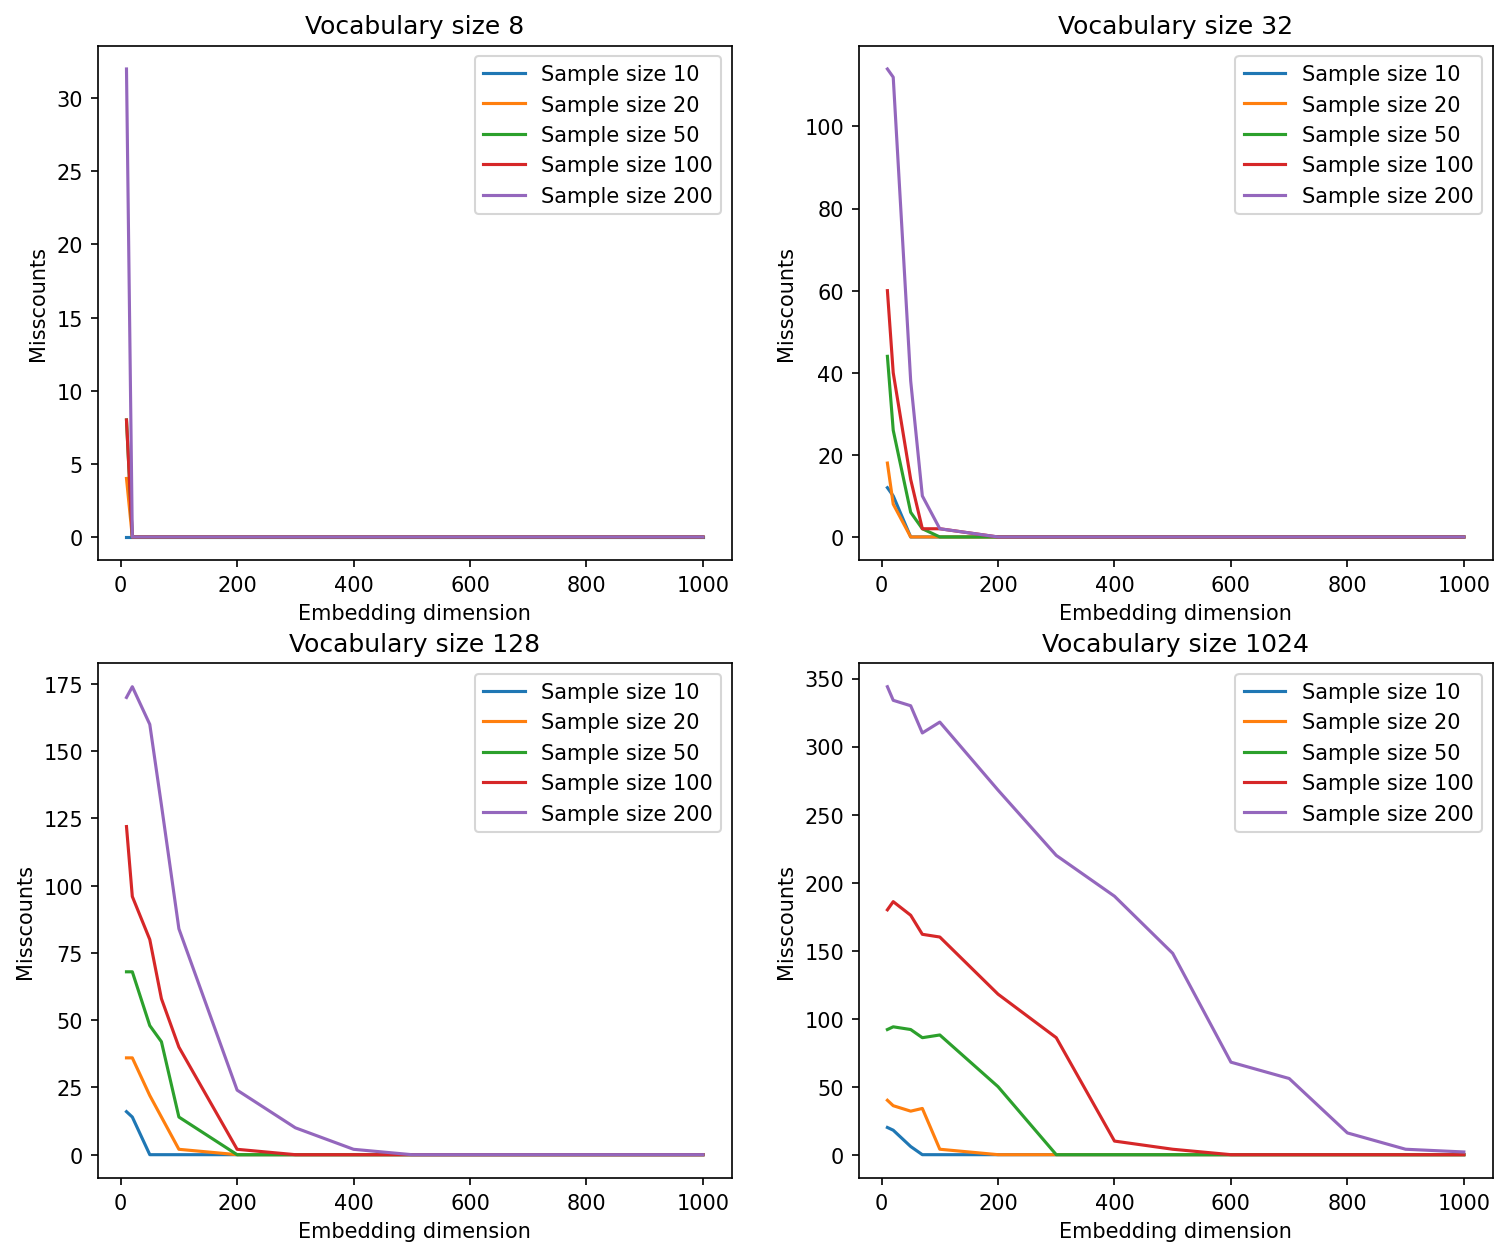

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10), dpi=150)

for num_vectors, ax in zip(num_distinct_vectors, axes.flatten()):
  miscounts_by_sample_size = miscounts_num_distinct_vectors[num_vectors]
  for sample_size, miscounts_by_emb_dim in miscounts_by_sample_size.items():
    emb_dims, miscount = zip(*sorted(miscounts_by_emb_dim.items()))
    ax.plot(emb_dims, miscount, label=f"Sample size {sample_size}")
  ax.set_title(f'Vocabulary size {num_vectors}')
  ax.legend()
  ax.set_xlabel('Embedding dimension')
  ax.set_ylabel('Miscounts')
  

As you can see, with sums of random vectors we can with quite good accuracy pick out exactly how many of each vector was part of the sum. Since a neural network relies on very similar mechanisms (dot product between weight vector and inputs), they also have this ability to pick out exactly what vector was part of a sum, provided the dimensionality is high enough.

In the case of neural networks, we often opimize the embedding vectors, so the results above should be thought of as a worst case. Our optimization can learn to set the embedding vectors so they perform as well as possible for the desired task.

## When you shouldn't sum vectors

In the examples we've shown above, the arguments for summing over concatenating comes from the assumption that the vectors are _high dimensional_ and contain _free parameters_, we can set their values to anything. This is why we can say something like _"we could just replace the vector matrix $W_u \mathbf{u}$ with $\mathbf{u}'$"_. If they are free, say $\mathbf{u}$ is actually a vector of measurements, then the arguments will not hold, sum and concatenation followed by a matrix multiplication will not be equivalent in terms of expressivity.

Also, if you have a set of scalars you would like to use as inputs, you can't sum them toghether and hope it will work (if they are in very different ranges, the nerual network might learn to disentangle this kind of sum, but we often standardize numerical variables so don't rely on this).

Likewise, if you have two vectors of different concatenated scalar _measurements_, summing them together followed by a matrix multiplication _will not_ be the same as concatenating them.